# End-to-End Training

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pickle
import random
import time

from ssd.ssd import SSD, Detector, UpSample, DownSample
from ssd.ssd_loss import MultiboxLoss
from ssd.ssd_bbox import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

### load data

In [2]:
# some constants
NUM_CLASSES = 2 # remember the background 
input_shape = (300, 300, 3)

In [3]:
"""
tf.reset_default_graph()
## priorbox defined by ourselves
prior_tensor = tf.ones((1, 300, 300, 3))
ssd_net = SSD(input_shape, NUM_CLASSES)
_, priors = ssd_net(prior_tensor, PRIORS = True)
print(priors.shape)
"""

'\ntf.reset_default_graph()\n## priorbox defined by ourselves\nprior_tensor = tf.ones((1, 300, 300, 3))\nssd_net = SSD(input_shape, NUM_CLASSES)\n_, priors = ssd_net(prior_tensor, PRIORS = True)\nprint(priors.shape)\n'

In [8]:
# DEBUG by tensorboard

g = tf.Graph()
with g.as_default():
    #a = tf.placeholder(tf.float32, name="a")
    #b = tf.placeholder(tf.float32, name="b")
    #c = a + b
    ## priorbox defined by ourselves
    input_tensor = tf.ones((1, 300, 300, 3))
    ssd_net = SSD()
    feats = ssd_net(input_tensor)
    detect_net = Detector(input_shape, NUM_CLASSES)
    priors = detect_net(feats, PRIORS=True)
    print(priors.shape)
    
tf.summary.FileWriter("logs", g).close()

(?, 6498, 8)


In [9]:
with g.as_default():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        priors_np = sess.run(priors)

# save priors tensor
with open('./data/priors300.pkl', 'wb') as handle:
    pickle.dump(np.squeeze(priors_np), handle)

In [3]:
# load priors tensor
with open('./data/priors300.pkl', 'rb') as handle:
    priors_np = pickle.load(handle)
    print(priors_np.shape)

(6498, 8)


### bbox

In [4]:
#sess = tf.InteractiveSession()
#sess.run(tf.global_variables_initializer())
#priors_np = np.squeeze(sess.run(priors))
bbox_util = BBoxUtility(NUM_CLASSES, priors_np)

In [5]:
print([None,] + list(priors_np.shape))

[None, 6498, 8]


#### load data

In [6]:
seq_length = 4
batch_size = 4

### old data

In [8]:
# load annotations
with open('./data/0254.pkl', 'rb') as handle:
    annotation0254 = pickle.load(handle)

In [9]:
## bounding box ground truth
gt = dict(pickle.load(open('./data/0254.pkl', 'rb')))
#keys = list(gt.keys())
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)
print(num_train)
print(num_val)

58
14


### new data

In [7]:
from ssd.preprocess import *
path_prefixs = ['./data/0247img/', './data/0249img/', './data/0251img/', './data/0254img/']

Using TensorFlow backend.


In [8]:
gt = dict()
train_keys = dict()
val_keys = dict(())
num_train = 0
num_val = 0
for path in path_prefixs:
    file = path.replace("img/", ".pkl")
    ## bounding box ground truth
    gt[path] = dict(pickle.load(open(file, 'rb')))
    #keys = list(gt.keys())
    keys = sorted(gt[path].keys())
    tmp_num_train = int(round(0.8 * len(keys)))
    print(tmp_num_train, "/", len(keys))
    num_train += tmp_num_train
    train_keys[path] = keys[:tmp_num_train]
    val_keys[path] = keys[tmp_num_train:]
    num_val += len(val_keys[path])
print(num_train)
print(num_val)

23 / 29
26 / 32
54 / 68
58 / 72
161
40


In [9]:
# batch_size = 4
gen = SeqGenerator(gt, bbox_util, batch_size, path_prefixs,
                train_keys, val_keys, input_shape, seq_length)

In [10]:
train_generator = gen.generate(True)
val_generator = gen.generate(False)

## Conv2DLSTM

#### final end-to-end model

In [14]:
#tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    seq_input_ph = tf.placeholder(tf.float32, [None, seq_length] + list(input_shape), name="input_image")
    gt_ph = tf.placeholder(tf.float32, [None, priors_np.shape[0], 4+NUM_CLASSES+priors_np.shape[1]], name="ground_truth")

    with tf.variable_scope("ssd_net"):
        ssd_net = SSD()
        ssd_input = tf.reshape(seq_input_ph, [-1,]+list(input_shape), name="reshape_seq_input")
        feats = ssd_net(ssd_input)
        #seq_feats = tf.reshape(ssd_input, [-1, seq_length]+list(input_shape), name="reshape_seq")

    #with tf.variable_scope("up_net"):
    #    upsample_net = UpSample()
    #    feats_up, up_factors = upsample_net(feats)
    #    seq_feats_up = tf.reshape(ssd_input, [-1, seq_length]+feats_up.get_shape().as_list()[-3:], name="reshape_seq_up")

    with tf.variable_scope("core_conv_lstm"):
        pred_feats = []
        for i, feat in enumerate(feats):
            seq_feat = tf.reshape(feat, [-1, seq_length]+feat.get_shape().as_list()[-3:], name="reshape_seq_{}".format(i))
            cell = tf.contrib.rnn.Conv2DLSTMCell(input_shape=feat.get_shape().as_list()[-3:], 
                                                 output_channels=feat.get_shape().as_list()[-1], kernel_shape=[5,5], name="convrnncell_{}".format(i))
            init_state = cell.zero_state(batch_size, tf.float32)
            outputs, final_state = tf.nn.dynamic_rnn(cell, seq_feat, dtype=tf.float32, scope="rnn_{}".format(i))
            pred_feats.append(final_state[-1])
            
        # last feature vector
        #seq_feat = tf.reshape(feats[-1], [-1, seq_length]+feats[-1].get_shape().as_list()[-1:], name="last_reshape_seq")
        #cell = tf.contrib.rnn.LSTMCell(128)
        #init_state = cell.zero_state(batch_size, tf.float32)
        #outputs, final_state = tf.nn.dynamic_rnn(cell, seq_feat, dtype=tf.float32, scope="last_dense_rnn")
        #pred_feats.append(final_state[-1])
        
    #with tf.variable_scope("down_pooling"):
    #    down_net = DownSample()
    #    feats_down = down_net(final_state[-1], up_factors) # final_state: (c, h)
        
    with tf.variable_scope("final_prediction"):
        detector = Detector(input_shape, NUM_CLASSES)
        #predictions = detector(feats, PRIORS=False)
        final_predictions = detector(pred_feats, PRIORS=False)
        
    with tf.variable_scope("loss"):
        loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss(gt_ph, final_predictions)
    
    with tf.variable_scope("train"):
        global_step = tf.Variable(0, trainable=False)
        lr = tf.train.exponential_decay(3e-4, global_step, num_train//batch_size, 0.9, staircase=True, name="lr")
        train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss, global_step=global_step)

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
tf.summary.FileWriter("logs", g).close()

#### train

In [11]:
tf.reset_default_graph()
#g = tf.Graph()
#with g.as_default():
seq_input_ph = tf.placeholder(tf.float32, [None, seq_length] + list(input_shape), name="input_image")
gt_ph = tf.placeholder(tf.float32, [None, priors_np.shape[0], 4+NUM_CLASSES+priors_np.shape[1]], name="ground_truth")
seq_gt_ph = tf.placeholder(tf.float32, [None, seq_length, priors_np.shape[0], 4+NUM_CLASSES+priors_np.shape[1]], name="detect_ground_truth")

with tf.variable_scope("ssd_net"):
    ssd_net = SSD()
    ssd_input = tf.reshape(seq_input_ph, [-1,]+list(input_shape), name="reshape_seq_input")
    feats = ssd_net(ssd_input)
    #seq_feats = tf.reshape(ssd_input, [-1, seq_length]+list(input_shape), name="reshape_seq")

#with tf.variable_scope("up_net"):
#    upsample_net = UpSample()
#    feats_up, up_factors = upsample_net(feats)
#    seq_feats_up = tf.reshape(ssd_input, [-1, seq_length]+feats_up.get_shape().as_list()[-3:], name="reshape_seq_up")

with tf.variable_scope("core_conv_lstm"):
    pred_feats = []
    for i, feat in enumerate(feats):
        seq_feat = tf.reshape(feat, [-1, seq_length]+feat.get_shape().as_list()[-3:], name="reshape_seq_{}".format(i))
        cell = tf.contrib.rnn.Conv2DLSTMCell(input_shape=feat.get_shape().as_list()[-3:], 
                                             output_channels=feat.get_shape().as_list()[-1], kernel_shape=[7,7], name="convrnncell_{}".format(i))
        init_state = cell.zero_state(batch_size, tf.float32)
        outputs, final_state = tf.nn.dynamic_rnn(cell, seq_feat, dtype=tf.float32, scope="rnn_{}".format(i))
        pred_feats.append(final_state[-1])

    # last feature vector
    #seq_feat = tf.reshape(feats[-1], [-1, seq_length]+feats[-1].get_shape().as_list()[-1:], name="last_reshape_seq")
    #cell = tf.contrib.rnn.LSTMCell(128)
    #init_state = cell.zero_state(batch_size, tf.float32)
    #outputs, final_state = tf.nn.dynamic_rnn(cell, seq_feat, dtype=tf.float32, scope="last_dense_rnn")
    #pred_feats.append(final_state[-1])

#with tf.variable_scope("down_pooling"):
#    down_net = DownSample()
#    feats_down = down_net(final_state[-1], up_factors) # final_state: (c, h)
#with tf.variable_scope("detection"):
#    input_detector = Detector(input_shape, NUM_CLASSES)

with tf.variable_scope("detection", reuse=tf.AUTO_REUSE):
    detector = Detector(input_shape, NUM_CLASSES)
    #predictions = detector(feats, PRIORS=False)
    detections = detector(feats, PRIORS=False)
    final_predictions = detector(pred_feats, PRIORS=False)

with tf.variable_scope("loss"):
    loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss(gt_ph, final_predictions)

with tf.variable_scope("detection_loss"):
    seq_gt_ph_flat = tf.reshape(seq_gt_ph, [-1,]+[priors_np.shape[0], 4+NUM_CLASSES+priors_np.shape[1]], name="reshape_seq_gt")
    detect_loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss(seq_gt_ph_flat, detections)

#with tf.variable_scope("total_loss"):
#    total_loss = loss + detect_loss

with tf.variable_scope("train"):
    global_step = tf.Variable(0, trainable=False)
    lr = tf.train.exponential_decay(3e-4, global_step, num_train//batch_size, 0.9, staircase=True, name="lr")
    trainer = tf.train.AdamOptimizer(learning_rate=lr)
    
    # get gradients
    rnn_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "core_conv_lstm")
    #rnn_grads = tf.gradients(loss,rnn_vars)
    
    cnn_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "ssd_net")
    cnn_vars += tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "detection")
    #cnn_grads = tf.gradients(detect_loss,cnn_vars)
    
    train_cnn_op = trainer.minimize(detect_loss, global_step=global_step)
    train_rnn_op = trainer.minimize(loss, global_step=global_step)
    #train_cnn_op = trainer.minimize(detect_loss, var_list=cnn_vars, global_step=global_step)
    #train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss, global_step=global_step)

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [14]:
train_cnn_loss_hist = []
train_rnn_loss_hist = []
nb_epoch = 20
for e in range(nb_epoch):
    # training phase
    start = time.time()
    cnt = 0
    for sample in train_generator:
        _, train_input, train_target, _, train_seq_gt = sample
        train_cnn_loss, _ = sess.run([detect_loss, train_cnn_op], feed_dict={seq_input_ph: train_input, seq_gt_ph: train_seq_gt})
        train_rnn_loss, _ = sess.run([loss, train_rnn_op], feed_dict={seq_input_ph: train_input, gt_ph: train_target})
        train_cnn_loss_hist.append(np.mean(train_cnn_loss))
        train_rnn_loss_hist.append(np.mean(train_rnn_loss))
        
        cnt += 1
        #print("training {}/{}, minibatch cnn loss: {}, rnn loss: {}".format(cnt*batch_size, num_train, np.mean(train_cnn_loss), np.mean(train_rnn_loss)))
        if cnt > (num_train//batch_size):
            cnt = 0
            break
        
    # validation phase
    val_loss = 0.0
    for sample in val_generator:
        _, val_input, val_target, _, val_seq_gt = sample
        val_loss += np.sum(sess.run(loss, feed_dict={seq_input_ph: val_input, gt_ph: val_target}))
        cnt += 1
        if cnt > (num_val//batch_size):
            cnt = 0
            break
    
    # print progress
    verbose_cnn_loss = np.mean(train_cnn_loss_hist[-(num_train//batch_size+1):])
    verbose_rnn_loss = np.mean(train_rnn_loss_hist[-(num_train//batch_size+1):])
    verbose_val_loss = val_loss/((num_val//batch_size+1)*batch_size)
    print("epoch {}/{}, train cnn loss: {}, train rnn loss: {}, val loss: {}, time: {}".format(e+1, nb_epoch, verbose_cnn_loss, verbose_rnn_loss, verbose_val_loss, time.time()-start))

epoch 1/20, train cnn loss: 3.4621152877807617, train rnn loss: 3.695248603820801, val loss: 2.821349404074929, time: 695.6436560153961
epoch 2/20, train cnn loss: 2.167508125305176, train rnn loss: 2.790397882461548, val loss: 2.477507786317305, time: 695.0045936107635
epoch 3/20, train cnn loss: 1.4997831583023071, train rnn loss: 2.650834560394287, val loss: 2.5447602705522017, time: 695.1262054443359
epoch 4/20, train cnn loss: 1.2014878988265991, train rnn loss: 2.555718183517456, val loss: 2.6073906421661377, time: 696.304438829422
epoch 5/20, train cnn loss: 1.0509790182113647, train rnn loss: 2.4230782985687256, val loss: 2.513708331368186, time: 696.7321979999542
epoch 6/20, train cnn loss: 0.9417141079902649, train rnn loss: 2.3953511714935303, val loss: 2.3115471601486206, time: 698.5235390663147
epoch 7/20, train cnn loss: 0.8842310905456543, train rnn loss: 2.3359463214874268, val loss: 2.462117238478227, time: 699.441356420517
epoch 8/20, train cnn loss: 0.786536157131195

In [22]:
# save model
save_path = saver.save(sess, "./models/full300_first2.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: ./models/full300_first2.ckpt


### evaluate

In [15]:
for sample in train_generator:
    seq_keys, seq_eval_input, _, seq_eval_target_img, seq_eval_seq_gt = sample
    break

In [16]:
eval_pred = sess.run(final_predictions, feed_dict={seq_input_ph: seq_eval_input})
results = bbox_util.detection_out(eval_pred)

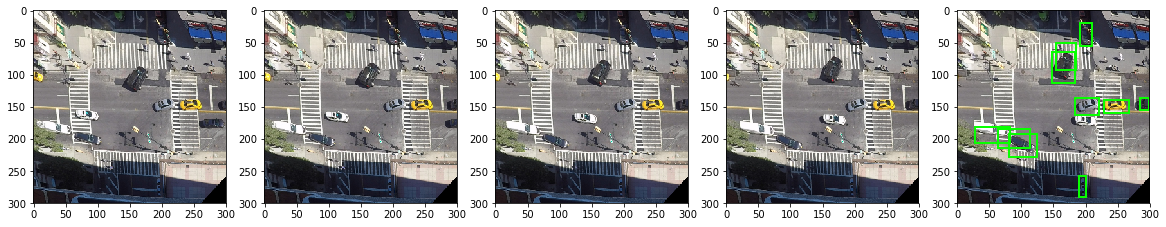

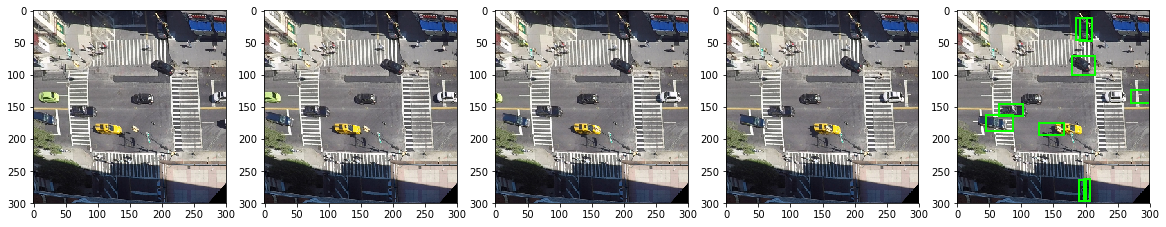

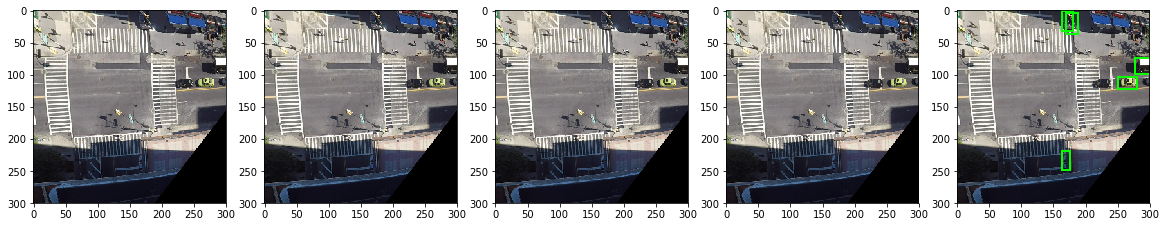

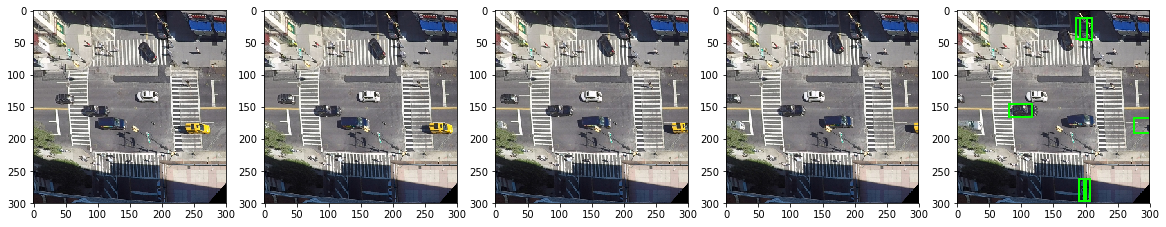

In [21]:
for i, result in enumerate(results[:]):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.40]
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()
    
    f, axarr = plt.subplots(1, seq_length+1, figsize=(20,100))
    #plt.imshow(img / 255.)
    #currentAxis = plt.gca()
    for j in range(seq_length):
        img = seq_eval_input[i,j,:,:,:]
        axarr[j].imshow((img*255.).astype("uint8")[:,:,::-1])
    img = seq_eval_target_img[i,:,:,:]
    axarr[-1].imshow(img.astype("uint8")[:,:,::-1])

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
        #display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        axarr[-1].add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        #currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()